# **SVC tuned model**

For this competition, the objective is to use the test dataset to predict whether a rookie NBA player will be playing in the NBA after 5 years. In a never ending quest to find the next Michael Jordan or Kobe Bryant, NBA teams are looking to invest in young players and want to know, with evidence-based analysis, whether their investments will pay off. This vignette will detail the steps undertaken to create a predictive model and the accuracy of the model against the stated aims.

In [4]:
#Initial imports
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
from src.common_lib import DataReader, NBARawData
from sklearn.svm import SVC

## **Data input and cleansing**

The nominated dataset for training and testing was supplied by the kaggle competition. The training dataset is called train.csv and the test dataset is called test.csv. 

In [5]:
#Load dataset using common function DataReader.read_data()
data_reader = DataReader()
# Load Raw Train Data
df_train = data_reader.read_data(NBARawData.TRAIN)
# Load Test Raw Data
df_test = data_reader.read_data(NBARawData.TEST)

In [6]:
#For train dataframe, remove redundant column 'Id_old'
#cols_drop = ["Id", "Id_old"]
#df_train.drop(cols_drop, axis=1, inplace=True)
df_train.drop('Id_old', axis=1, inplace=True)
df_train.columns = df_train.columns.str.strip()
df_train.describe

<bound method NDFrame.describe of          Id  GP   MIN   PTS  FGM  FGA   FG%  3P Made  3PA   3P%  ...  FTA  \
0      3799  80  24.3   7.8  3.0  6.4  45.7      0.1  0.3  22.6  ...  2.9   
1      3800  75  21.8  10.5  4.2  7.9  55.1     -0.3 -1.0  34.9  ...  3.6   
2      3801  85  19.1   4.5  1.9  4.5  42.8      0.4  1.2  34.3  ...  0.6   
3      3802  63  19.1   8.2  3.5  6.7  52.5      0.3  0.8  23.7  ...  1.5   
4      3803  63  17.8   3.7  1.7  3.4  50.8      0.5  1.4  13.7  ...  0.5   
...     ...  ..   ...   ...  ...  ...   ...      ...  ...   ...  ...  ...   
7995  11794  32   9.2   1.8  0.7  1.8  40.3     -0.1 -0.2  23.1  ...  0.6   
7996  11795  54   6.0   1.8  0.7  1.4  48.7      0.1  0.1   3.1  ...  0.4   
7997  11796  85  28.2  10.7  4.0  9.0  45.1      0.2  0.6  23.6  ...  3.9   
7998  11797  39   7.7   2.5  1.0  2.3  40.1     -0.3 -0.5  13.3  ...  0.7   
7999  11798  49  19.2   4.8  1.7  5.1  32.6      0.7  2.4  41.3  ...  1.3   

       FT%  OREB  DREB  REB  AST  STL  BL

In [7]:
#For test dataframe, remove redundant column 'Id_old'
df_test.drop('Id_old', axis=1, inplace=True)
df_test.columns = df_test.columns.str.strip()
df_test.describe

<bound method NDFrame.describe of         Id  GP   MIN   PTS  FGM   FGA   FG%  3P Made  3PA   3P%  FTM  FTA  \
0        0  56   9.1   4.0  1.6   3.7  43.7      0.1  0.3   7.3  0.7  1.2   
1        1  43  19.3  10.1  3.7   8.1  46.0      0.6  1.7  35.1  1.8  2.5   
2        2  82  33.9  11.3  4.9  10.6  45.6      0.5  1.9  44.8  1.8  2.7   
3        3  86  44.7  18.8  6.8  15.9  42.9      0.5  1.8  13.5  4.5  6.3   
4        4  58  12.3   4.7  1.6   4.0  40.0      0.5  1.7  38.7  1.1  1.3   
...    ...  ..   ...   ...  ...   ...   ...      ...  ...   ...  ...  ...   
3794  3794  84  21.2   8.7  3.4   6.7  50.2      0.0  0.0  -4.5  1.7  2.5   
3795  3795  49  16.3   6.4  2.9   6.6  44.4     -0.1 -0.4  19.8  1.0  1.9   
3796  3796  53   9.9   2.1  0.8   1.8  43.1     -0.4 -0.6   1.9  0.6  1.0   
3797  3797  89  38.3  14.5  5.4  11.8  45.2      0.5  1.2  24.7  2.5  2.9   
3798  3798  55  12.0   3.0  1.1   2.5  42.3      0.1  0.6  11.7  0.9  1.1   

       FT%  OREB  DREB  REB  AST  STL  BL

## **Negative values in dataset**

In [8]:
print(df_train.where(df_train < 0).count())

Id                0
GP                2
MIN               0
PTS               0
FGM               0
FGA               0
FG%               0
3P Made        1629
3PA            1658
3P%             878
FTM               0
FTA               0
FT%               1
OREB              0
DREB              0
REB               0
AST               0
STL               0
BLK            1048
TOV               0
TARGET_5Yrs       0
dtype: int64


## **Feature Correlation and Selection**

When there are two or more correlated features, multicollinearity can occur and this can lead to skewed or misleading results [1]. In order to reduce this from happening, the features have to be examined for colinearity. Pearson correlation was used for this analysis.

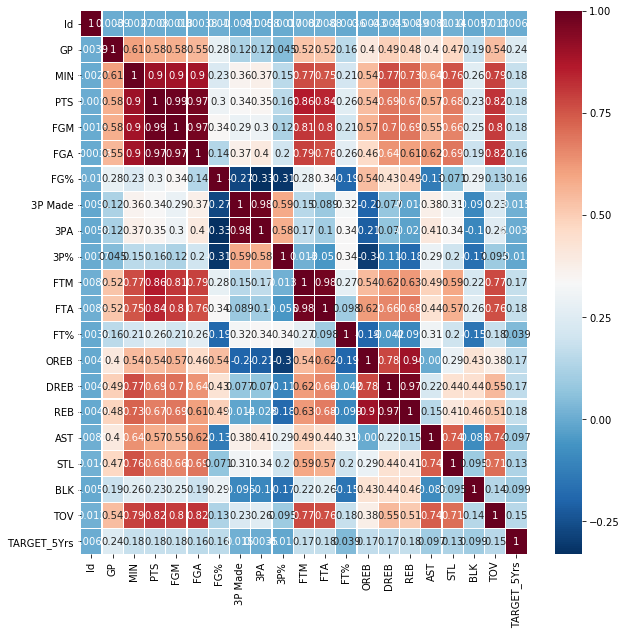

In [9]:
#Use Pearson Correlation to determine feature correlation 
pearsoncorr = df_train.corr('pearson')

#Create heatmap of pearson correlation factors
fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.2)

In [10]:
#Drop correlated features w/ score over 0.9 - retain "MINS", "3P MADE","FTM","REB"
cols_drop = ["PTS", "FGM", "FGA", "3PA", "FTA", "DREB", "OREB"]
df_train.drop(cols_drop, axis=1, inplace=True)
df_test.drop(cols_drop, axis=1, inplace=True)

In [11]:
# Split the training dataset using common function data_reader.splitdata
X_train, X_val, y_train, y_val  = data_reader.split_data(df_train)

## **Model Selection and Training**

For this week's hypothesis, the Support Vector Classification (SVC) model is being validated. 

In [12]:
#Create Optimised SVC Model
optmodel = SVC()

In [42]:
#Use GridSearchCV to optimise parameters
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(probability=False), param_grid, refit = True, verbose = 3, scoring="roc_auc", n_jobs=-2) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-2)]: Done 125 out of 125 | elapsed:   35.9s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-2,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=3)

In [43]:
#Print the optimised parameters
print(grid.best_params_) 

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


In [44]:
#Create model with the optimised parameters
model = SVC(C=10.0, break_ties=False, class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma=0.0001, kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False)

In [45]:
model.fit(X_train, y_train);

In [46]:
#Store model in /models
from joblib import dump
dump(model, '../models/SVC02.joblib')

['../models/SVC02.joblib']

In [47]:
#Create predictions for train and validation
y_train_preds = model.predict(X_train)
y_val_preds = model.predict(X_val)

In [35]:
#Evaluate train predictions
#from src.models.aj_metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix

In [48]:
y_train_preds

array([0, 1, 1, ..., 0, 1, 0])

In [49]:
#Train confusion matrix
print("ROC AUC Score:")
print(roc_auc_score(y_train,y_train_preds))
print(classification_report(y_train, y_train_preds)) 

ROC AUC Score:
0.7508784774595796
              precision    recall  f1-score   support

           0       0.35      0.81      0.49      1074
           1       0.95      0.69      0.80      5326

    accuracy                           0.71      6400
   macro avg       0.65      0.75      0.64      6400
weighted avg       0.85      0.71      0.75      6400



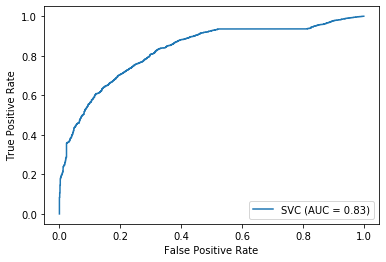

In [50]:
plot_roc_curve(model,X_train, y_train)

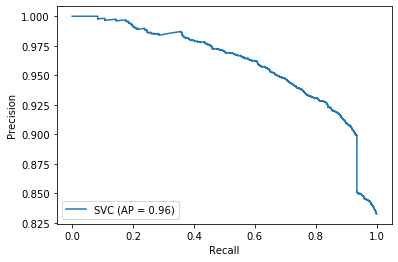

In [51]:
plot_precision_recall_curve(model,X_train,y_train)

In [55]:
#Validation set scores
print("ROC AUC Score:")
print(roc_auc_score(y_val,y_val_preds))
print("Confusion Matrix:")
print(classification_report(y_val, y_val_preds)) 

ROC AUC Score:
0.5913513215954757
Confusion Matrix:
              precision    recall  f1-score   support

           0       0.22      0.54      0.32       257
           1       0.88      0.64      0.74      1343

    accuracy                           0.63      1600
   macro avg       0.55      0.59      0.53      1600
weighted avg       0.77      0.63      0.67      1600



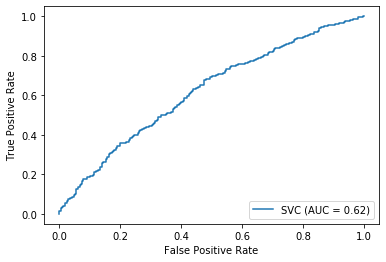

In [53]:
plot_roc_curve(model,X_val, y_val)

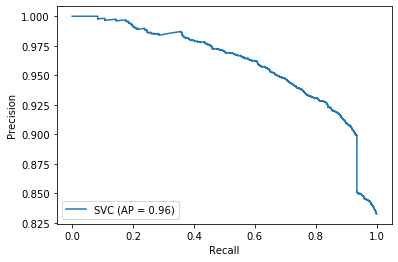

In [54]:
plot_precision_recall_curve(model,X_train,y_train)

After training and validation, the SVC model achieved an AUROC of 0.889 and 0.651 respectively. It is expected to do well in testing against the final target output.

## **Test output**

The output needs to be formatted to comply with the kaggle competition input requirements. The final steps detail this formatting,
as well as the outcome of the model's testing.

In [38]:
#Output predictions
X_test = df_test
y_test_preds = model.predict(X_test)

In [39]:
y_test_preds

array([1, 1, 1, ..., 0, 1, 1])

In [40]:
output = pd.DataFrame({'Id': range(0,3799), 'TARGET_5Yrs': [p for p in y_test_preds]})

In [41]:
output.to_csv("../reports/tay_donovan_submission_svc03.csv", index=False)

## **Outcome**

After outputting the predictions into kaggle, the final score was 0.504. This was not the highest achieved by Jump Shot so some further improvements can be made.